In [1]:
#Create the model

import csv
import os
import cv2
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
# Visualizations will be shown in the notebook.
%matplotlib inline
#import socketio
#import eventlet

In [2]:
samples = []
with open('./data4/driving_log.csv') as csv_table:
    read_data = csv.reader(csv_table)
    #read_data = pd.read_csv(csv_table, header = None)
    for line in read_data:
        samples.append(line)
    samples.pop(0)
print(np.array(samples).shape)

(10727, 7)


In [3]:
'''
def get_feature_label(data_samples):
    image_path = './data/IMG/'
    images = []
    measurements = []
    for line in data_samples:
        steering = float(line[3])
        image_name = line[0].split('/')[-1]
        image = mpimg.imread(image_path + image_name)
        measurements.append(steering)
        images.append(image)
    return images, measurements

'''

"\ndef get_feature_label(data_samples):\n    image_path = './data/IMG/'\n    images = []\n    measurements = []\n    for line in data_samples:\n        steering = float(line[3])\n        image_name = line[0].split('/')[-1]\n        image = mpimg.imread(image_path + image_name)\n        measurements.append(steering)\n        images.append(image)\n    return images, measurements\n\n"

In [4]:
# read images
def get_feature_label(data_samples):
    image_path = './data4/IMG/'
    images = []
    measurements = []
    correction = 0.1  # correct steer angle for left and right camera
    
    for line in data_samples:
        img_name_center = line[0].split('/')[-1]
        img_name_left = line[1].split('/')[-1]
        img_name_right = line[2].split('/')[-1]
    
        img_center = mpimg.imread(image_path + img_name_center)
        img_left = mpimg.imread(image_path + img_name_left)
        img_right = mpimg.imread(image_path + img_name_right)
        image = [img_center, img_left, img_right]
    
        steering_center = float(line[3])
        steering_left = steering_center + correction
        steering_right = steering_center - correction
    
        steering = [steering_center, steering_left, steering_right]
    
        measurements.extend(steering)
        images.extend(image)
    return images, measurements


In [5]:

from sklearn.model_selection import train_test_split
train_samples, validation_samples = train_test_split(samples, test_size=0.2)


In [6]:
images, measurements = get_feature_label(train_samples)
# data augumentation
aug_images = []
aug_measurements = []
for image, measurement in zip(images,measurements):
    aug_images.append(image)
    aug_measurements.append(measurement)
    aug_images.append(cv2.flip(image,1))
    aug_measurements.append(measurement*(-1.0))

train_features = np.array(aug_images)
train_labels = np.array(aug_measurements)

In [7]:
images, measurements = get_feature_label(validation_samples)
validation_features = np.array(images)
validation_labels = np.array(measurements)

<class 'float'> 6438


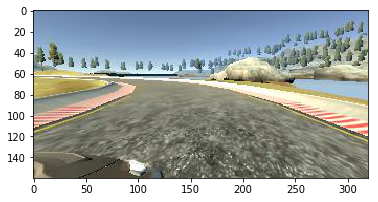

In [8]:
print(type(measurements[0]),len(measurements))
#print(len(images))
#img = cv2.imread(images[0],0)
index = np.random.randint(len(images))
plt.figure(figsize = (6,6))
plt.imshow(images[index])
#print(images[0].shape)

In [9]:
BATCH_SIZE = 64

# create a Generator
def generator (sample_features, sample_labels, batch_size = 32):
    num_examples = len(sample_features)
    while True:
        for offset in range(0,num_examples,batch_size):
            batch_X_train = sample_features[offset:offset+batch_size]
            batch_y_train = sample_labels[offset:offset+batch_size]
            yield [batch_X_train, batch_y_train]

train_generator = generator (train_features, train_labels, batch_size = BATCH_SIZE)
validation_generator = generator (validation_features, validation_labels, batch_size = BATCH_SIZE)

In [10]:
from keras.models import Sequential
from keras.layers.core import Dense, Flatten, Lambda, Activation, Dropout

from keras.layers.convolutional import Convolution2D, Cropping2D
from keras.layers.pooling import MaxPooling2D

/Users/hzhang/MyInstall/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:34: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [11]:
#help(Sequential().fit_generator)

In [12]:
model = Sequential()
#first layer
model.add(Lambda(lambda x: (x / 255.0) - 0.5, input_shape=(160,320,3)))
model.add(Cropping2D(cropping=((70,25),(0,0))))
model.add(Convolution2D(32,3,3,input_shape = (160,320,3)))
model.add(MaxPooling2D((2,2)))
model.add(Activation('relu'))
# flatten the convolutional layer
model.add(Flatten())  
# use dropout 
model.add(Dropout(0.8))
# output layer
model.add(Dense(1))

model.compile(loss='mse', optimizer='adam',metrics = ['accuracy'])
#model.fit(X_train, y_train, validation_split = 0.2, shuffle = True, nb_epoch = 6)
history_object = model.fit_generator(train_generator, steps_per_epoch= int(np.ceil(len(train_samples)/BATCH_SIZE)),\
    validation_data=validation_generator, validation_steps=int(np.ceil(len(validation_samples)/BATCH_SIZE)), epochs=10, verbose = 1)
model.save('model.h5')

/Users/hzhang/MyInstall/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:5: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(32, (3, 3), input_shape=(160, 320,...)`
  """


Epoch 1/10
135/135 [==============================] - 119s 883ms/step - loss: 0.1161 - acc: 0.1388 - val_loss: 0.0100 - val_acc: 0.1595
Epoch 2/10
135/135 [==============================] - 113s 835ms/step - loss: 0.0149 - acc: 0.1433 - val_loss: 0.0106 - val_acc: 0.1448
Epoch 3/10
135/135 [==============================] - 111s 819ms/step - loss: 0.0129 - acc: 0.1486 - val_loss: 0.0093 - val_acc: 0.1530
Epoch 4/10
135/135 [==============================] - 109s 810ms/step - loss: 0.0115 - acc: 0.1514 - val_loss: 0.0100 - val_acc: 0.1471
Epoch 5/10
135/135 [==============================] - 132s 976ms/step - loss: 0.0121 - acc: 0.1447 - val_loss: 0.0089 - val_acc: 0.1479
Epoch 6/10
135/135 [==============================] - 110s 816ms/step - loss: 0.0116 - acc: 0.1495 - val_loss: 0.0086 - val_acc: 0.1572
Epoch 7/10
135/135 [==============================] - 110s 816ms/step - loss: 0.0101 - acc: 0.1475 - val_loss: 0.0083 - val_acc: 0.1480
Epoch 8/10
135/135 [============================

dict_keys(['val_loss', 'val_acc', 'loss', 'acc'])


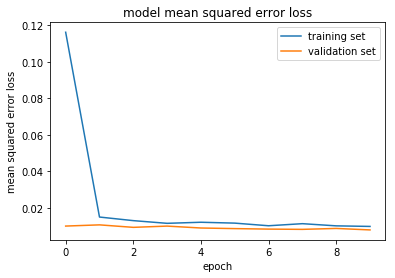

In [13]:
### print the keys contained in the history object
print(history_object.history.keys())

### plot the training and validation loss for each epoch
plt.plot(history_object.history['loss'])
plt.plot(history_object.history['val_loss'])
plt.title('model mean squared error loss')
plt.ylabel('mean squared error loss')
plt.xlabel('epoch')
plt.legend(['training set', 'validation set'], loc='upper right')
plt.show()
